## map2loop: From geology layers to outputs to various 3D modelling programs- Hamersley example-gempy

This notebook reads in three layers from  local or remote sources:  geology polygons, orientation data and fault and fold axial trace  polylines; and calculates the topological relationships between the different features. Requires compiled cpp code from Vitaliy Ogarko

This all gets fed into successive tolopogical and geometric transfroms that end up feeding into gempy to make a 3D model 

<img src='../graphics/map_sm.png'>

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import sys
import stat
import functools 
import operator  
import matplotlib
import networkx as nx
import rasterio
from shapely.geometry import Polygon
from map2loop import m2l_utils
from map2loop import m2l_topology
from map2loop import m2l_geometry
from map2loop import m2l_interpolation
from map2loop import m2l_export
import gempy as gp
%matplotlib inline

#newwd="C:\\Users\\00073294\Dropbox\\loop_minex\\map2model\\"
#os.chdir(newwd)
print("Current Working Directory " )

gdal_data = os.environ['GDAL_DATA']
print("***",gdal_data)
print('is dir: ' + str(os.path.isdir(gdal_data)))
gcs_csv = os.path.join(gdal_data, 'gcs.csv')
print('is file: ' + str(os.path.isfile(gcs_csv)))
st = os.stat(gcs_csv)
print('is readable: ' + str(bool(st.st_mode & stat.S_IRGRP)))
os.environ['PROJ_LIB']=r"C:\\Users\\00073294\\AppData\\Local\\Continuum\\anaconda3\\Lib\\site-packages\\pyproj\\proj_dir\\share\\proj"
print(os.getenv('PROJ_LIB'))
print(os.getcwd())
m2l_utils.v()

Current Working Directory 
*** C:\Program Files\PostgreSQL\11\gdal-data
is dir: True
is file: True
is readable: True
C:\\Users\\00073294\\AppData\\Local\\Continuum\\anaconda3\\Lib\\site-packages\\pyproj\\proj_dir\\share\\proj
C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\notebooks
0.0.50


## Create bounding box based on inputs

In [2]:
test_data_name='test_data3'

test_data_path='../'+test_data_name+'/'

os.chdir(test_data_path)
%run -i "m2l_config.py"
#%run -i "../test_data3/m2l_config.py"
print(os.getcwd())

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)


Default parameters loaded from ../test_data3/m2l_config.py:
#ROI

step_out=0.1   #padding arounf dtm to ensure reprojected dtm covers target area (in degrees)
inset=0      #unused??

minx=500057  #region of interest coordinates in metre-based system (or non-degree system)
maxx=603028
miny=7455348
maxy=7567953
model_top=1200
model_base=-8200

#PATHS

local_paths=True       #flag to use local or WFS source for data inputs (True = local)

test_data_path='../test_data3/'
m2m_cpp_path='../m2m_cpp/'

geology_file='hams2_geol.shp'   #input geology file (if local)
fault_file='GEOS_GEOLOGY_LINEARSTRUCTURE_500K_GSD.shp' #input fault file (if local)
structure_file='hams2_structure.shp' #input bedding orientation file (if local)
mindep_file='mindeps_2018.shp' #input mineral deposit file (if local)


#CRS

src_crs = {'init': 'EPSG:4326'}  # coordinate reference system for imported dtms (geodetic lat/long WGS84)
dst_crs = {'init': 'EPSG:28350'} # coordinate system for data

#codes and labels these r

In [3]:

fold_decimate=2         

contact_decimate=5

use_interpolations=True       #use interpolated dips/contacts as additional constraints

use_fat=True                   #use fold axial trace orientation hints

    
#local_paths=True              #use local copies of data

pluton_form='domes'

fault_dip=90.0

min_fault_length=20

## Preprocess data to ensure it meets gempy's requirements

In [4]:
if(local_paths): ###############FUDGE#############
    use_gcode=('Hamersley_Group','Fortescue_Group','Wyloo_Group','Shingle_Creek_Group','Turee_Creek_Group','A_mgn_PRK',  'A_mgn_PMI' ) ################# MOVE UP   #########################
else:
    use_gcode=('Hamersley_Group','Fortescue_Group','Wyloo_Group','Shingle_Creek_Group','Turee_Creek_Group','A_mgn_PMI_7366',  'A_mgn_PRK_16193' ) ################# MOVE UP   #########################


#print('only processing',use_gcode)

#inputs=('invented_orientations','interpolated_orientations','intrusive_orientations','fat_orientations','near_fault_orientations')
inputs=('invented_orientations','interpolated_orientations','fat_orientations')

m2l_geometry.tidy_data(output_path,tmp_path,use_gcode,use_interpolations,use_fat,pluton_form,inputs)

## Analyse fault-fault topology


C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


cycles [['Fault_16825', 'Fault_7966', 'Fault_313', 'Fault_2837']]


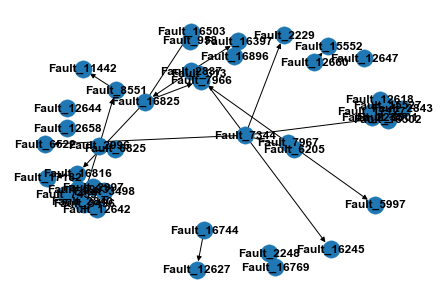

In [5]:
m2l_topology.parse_fault_relationships(graph_path,tmp_path,output_path)

# loop2gempy test 


<font face color='red'>The way this loads data to gempy is not right, so all the units end up in one series... but it gives the basic idea </font>


## Now we define the basic model and load the orientation and lithological information
mj: We inset the model dimensions as once reprojects the edge pixels of the topography are undefined. Probably doesn't need to be that extreme (unit is metres). Could use parameter <b>maxtopo</b> to 

Active grids: ['regular']
Cropped raster to geo_model.grid.extent.
[ 500057  603028 7455348 7567953] [191 174]
storing converted file...
Active grids: ['regular' 'topography']
Shingle_Creek_Group
Turee_Creek_Group
Hamersley_Group
Fortescue_Group
A_s_PMI
A_mgn_PMI
A_mgn_PRK
7 ['Shingle_Creek_Group', 'Turee_Creek_Group', 'Hamersley_Group', 'Fortescue_Group', 'A_s_PMI', 'A_mgn_PMI', 'A_mgn_PRK']
Compiling theano function...
Compilation Done!


C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\gempy\core\solution.py:253: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e))


closing vtk


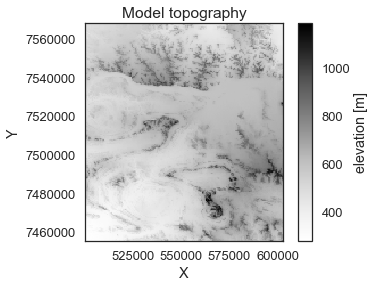

In [6]:
import winsound
duration = 700  # milliseconds
freq = 1100  # Hz
winsound.Beep(freq, duration)

vtk=False

m2l_export.loop2gempy(test_data_name,tmp_path,vtk_path,output_path+'orientations_clean.csv',output_path+'contacts_clean.csv',tmp_path+'groups_clean.csv',dtm_reproj_file,bbox,model_base, model_top,vtk)
